# ***Problem Statement***

Traditional chatbots struggle with context-aware question answering where they need to:
- Understand and remember story context
- Process natural language questions
- Provide accurate answers based on stored information

# ***Objective***

Build an intelligent chatbot that can:
1. Process story contexts and questions
2. Learn relationships between entities and locations
3. Answer questions accurately based on stored memories
4. Handle simple reasoning tasks (e.g., "Is John in the kitchen?")

# ***Key Challenges Addressed***
- Context retention and memory management
- Natural language understanding
- Sequence-to-sequence learning
- Multi-modal input processing (stories + questions)


# ***ENVIRONMENT SETUP & LIBRARY IMPORTS***

In [1]:
# Install required packages
!pip install keras tensorflow numpy pandas matplotlib

# Import essential libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Keras/TensorFlow imports for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Embedding, Input, Activation, Dense,
                                   Permute, Dropout, add, dot, concatenate, LSTM)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.19.0


# ***Data Structure Overview***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open("/content/drive/MyDrive/Chatbot_NLP/Train-Data Set.txt", "rb") as fp:
    Train_data = pickle.load(fp)

In [4]:
with open("/content/drive/MyDrive/Chatbot_NLP/Test-Data Set.txt", "rb") as fp:
    Test_data = pickle.load(fp)

In [5]:
print(Test_data[:5])

[(['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.'], ['Is', 'John', 'in', 'the', 'kitchen', '?'], 'no'), (['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.', 'Mary', 'discarded', 'the', 'milk', '.', 'John', 'went', 'to', 'the', 'garden', '.'], ['Is', 'John', 'in', 'the', 'kitchen', '?'], 'no'), (['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.', 'Mary', 'discarded', 'the', 'milk', '.', 'John', 'went', 'to', 'the', 'garden', '.', 'Daniel', 'moved', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'to', 'the', 'garden', '.'], ['Is', 'John', 'in', 'the', 'garden', '?'], 'yes'), (['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.', 'Mary', 'discarded', 'the', 'milk', '.', 'John', 'went', 'to', 'the', 'garden', '.', 'Daniel', 'moved', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'to', 'the', 'garden', '.', 'Daniel', 'travelled', 'to', 

In [6]:
def analyze_data_structure(train_data, test_data):
    """Analyze and display data characteristics"""

    print(f"Training data type: {type(train_data)}")
    print(f"Test data type: {type(test_data)}")
    print(f"Training samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")

    # Display sample data point
    if len(train_data) > 0:
        print(f"\n📝 Sample Training Example:")
        print(f"Story: {' '.join(train_data[0][0])}")
        print(f"Question: {' '.join(train_data[0][1])}")
        print(f"Answer: {train_data[0][2]}")

    return train_data, test_data

Train_data, Test_data = analyze_data_structure(Train_data, Test_data)

Training data type: <class 'list'>
Test data type: <class 'list'>
Training samples: 10000
Test samples: 1000

📝 Sample Training Example:
Story: Mary moved to the bathroom . Sandra journeyed to the bedroom .
Question: Is Sandra in the hallway ?
Answer: no


# ***VOCABULARY BUILDING & TEXT PREPROCESSING***
Vocabulary Construction

Building a comprehensive vocabulary from all text data:
1. Extract unique words from stories and questions
2. Add answer tokens ('yes', 'no')
3. Create word-to-index mapping using Keras Tokenizer

In [7]:
def build_vocabulary(train_data, test_data):
    """Build vocabulary from all available text data"""

    print("🔤 Building vocabulary...")

    # Initialize vocabulary set
    vocab = set()
    all_data = test_data + train_data

    # Extract vocabulary from stories and questions
    for story, question, answer in all_data:
        vocab = vocab.union(set(story))
        vocab = vocab.union(set(question))

    # Add answer vocabulary
    vocab.add('yes')
    vocab.add('no')

    print(f"📈 Vocabulary Statistics:")
    print(f"Total unique words: {len(vocab)}")
    print(f"Sample words: {list(vocab)[:10]}")

    return vocab, all_data

vocab, all_data = build_vocabulary(Train_data, Test_data)

🔤 Building vocabulary...
📈 Vocabulary Statistics:
Total unique words: 37
Sample words: ['milk', 'office', 'got', 'put', 'Mary', 'bedroom', '?', 'grabbed', 'to', 'down']


Sequence Length Analysis:
Max story length: 156
Average story length: 38.50
Max question length: 6
Average question length: 6.00


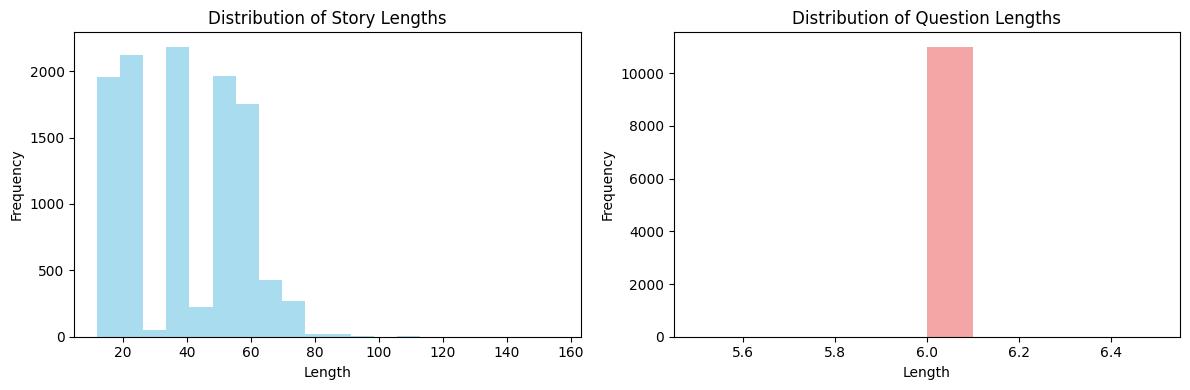

In [8]:
def analyze_sequence_lengths(all_data):
    """Analyze sequence lengths for padding purposes"""

    story_lengths = [len(data[0]) for data in all_data]
    question_lengths = [len(data[1]) for data in all_data]

    max_story_len = max(story_lengths)
    max_ques_len = max(question_lengths)

    print(f"Sequence Length Analysis:")
    print(f"Max story length: {max_story_len}")
    print(f"Average story length: {np.mean(story_lengths):.2f}")
    print(f"Max question length: {max_ques_len}")
    print(f"Average question length: {np.mean(question_lengths):.2f}")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(story_lengths, bins=20, alpha=0.7, color='skyblue')
    plt.title('Distribution of Story Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(question_lengths, bins=10, alpha=0.7, color='lightcoral')
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return max_story_len, max_ques_len

max_story_len, max_ques_len = analyze_sequence_lengths(all_data)

# ***TEXT VECTORIZATION & TOKENIZATION***
Text Vectorization Process

Converting text to numerical format:
1. Create tokenizer with no filters to preserve punctuation
2. Fit tokenizer on vocabulary
3. Convert text sequences to integer sequences
4. Pad sequences to uniform length

In [9]:
def setup_tokenizer(vocab):
    """Initialize and configure tokenizer"""

    tokenizer = Tokenizer(filters='')  # No filtering to preserve all tokens
    tokenizer.fit_on_texts(vocab)

    vocab_len = len(vocab) + 1  # +1 for padding token

    print(f"🎯 Tokenizer Configuration:")
    print(f"Vocabulary size: {vocab_len}")
    print(f"Sample word indices: {dict(list(tokenizer.word_index.items())[:10])}")

    return tokenizer, vocab_len

tokenizer, vocab_len = setup_tokenizer(vocab)

🎯 Tokenizer Configuration:
Vocabulary size: 38
Sample word indices: {'milk': 1, 'office': 2, 'got': 3, 'put': 4, 'mary': 5, 'bedroom': 6, '?': 7, 'grabbed': 8, 'to': 9, 'down': 10}


In [10]:
tokenizer.word_index

{'milk': 1,
 'office': 2,
 'got': 3,
 'put': 4,
 'mary': 5,
 'bedroom': 6,
 '?': 7,
 'grabbed': 8,
 'to': 9,
 'down': 10,
 'there': 11,
 'in': 12,
 'dropped': 13,
 'picked': 14,
 'took': 15,
 'kitchen': 16,
 'football': 17,
 'went': 18,
 'the': 19,
 'yes': 20,
 'hallway': 21,
 'is': 22,
 '.': 23,
 'sandra': 24,
 'left': 25,
 'up': 26,
 'back': 27,
 'john': 28,
 'daniel': 29,
 'discarded': 30,
 'moved': 31,
 'garden': 32,
 'journeyed': 33,
 'travelled': 34,
 'no': 35,
 'bathroom': 36,
 'apple': 37}

In [11]:
def vectorize_stories(data, tokenizer, max_story_len, max_ques_len):
    """Convert text data to numerical vectors"""

    print("🔢 Vectorizing text data...")

    X = []      # Stories
    Xq = []     # Questions
    Y = []      # Answers

    word_index = tokenizer.word_index

    for i, (story, query, answer) in enumerate(data):
        if i < 5: # Print for first 5 examples
            print(f"\nProcessing example {i+1}:")
            print(f"  Original Story: {story}")
            print(f"  Original Question: {query}")
            print(f"  Original Answer: {answer}")


        # Convert words to indices
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]

        if i < 5: # Print for first 5 examples
            print(f"  Story indices: {x}")
            print(f"  Question indices: {xq}")

        # One-hot encode answers
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1

        if i < 5: # Print for first 5 examples
            print(f"  Answer one-hot: {y}")


        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Pad sequences to uniform length
    X_padded = pad_sequences(X, maxlen=max_story_len)
    Xq_padded = pad_sequences(Xq, maxlen=max_ques_len)
    Y_array = np.array(Y)

    print(f"\n✅ Vectorization complete!")
    print(f"Stories shape: {X_padded.shape}")
    print(f"Questions shape: {Xq_padded.shape}")
    print(f"Answers shape: {Y_array.shape}")

    return X_padded, Xq_padded, Y_array


tokenizer, vocab_len = setup_tokenizer(vocab)
inputs_train, queries_train, answers_train = vectorize_stories(Train_data, tokenizer, max_story_len, max_ques_len)
inputs_test, queries_test, answers_test = vectorize_stories(Test_data, tokenizer, max_story_len, max_ques_len)

🎯 Tokenizer Configuration:
Vocabulary size: 38
Sample word indices: {'milk': 1, 'office': 2, 'got': 3, 'put': 4, 'mary': 5, 'bedroom': 6, '?': 7, 'grabbed': 8, 'to': 9, 'down': 10}
🔢 Vectorizing text data...

Processing example 1:
  Original Story: ['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.']
  Original Question: ['Is', 'Sandra', 'in', 'the', 'hallway', '?']
  Original Answer: no
  Story indices: [5, 31, 9, 19, 36, 23, 24, 33, 9, 19, 6, 23]
  Question indices: [22, 24, 12, 19, 21, 7]
  Answer one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Processing example 2:
  Original Story: ['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.']
  Original Question: ['Is', 'Daniel', 'in', 'the', 'bathroom', '?']
  Or

In [12]:
print(answers_train.shape)

(10000, 38)


In [13]:

print(answers_test.shape)

(1000, 38)


In [14]:
inputs_train.shape

(10000, 156)

In [15]:
print("First 5 samples of inputs_train:")
print(inputs_train[:5])

print("\nFirst 5 samples of queries_train:")
print(queries_train[:5])

print("\nFirst 5 samples of answers_train:")
print(answers_train[:5])

First 5 samples of inputs_train:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   5 31  9 19 36 23 24 33  9 19  6 23]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  5 31  9 19 36 23 24 33  9 19  6 23  5 18
  27  9 19  6 23 29 18 27  9 19 21 23]
 

# ***MODEL ARCHITECTURE & APPROACH***

This section details the architecture of the improved Memory Network model designed for context-aware question answering.

Key Components:
1. **Input Encoders**: Process stories with different representations, now with **L2 Regularization** and **Batch Normalization**.
   - Memory encoder (m): For storing contextual information.
   - Context encoder (c): For response generation.
2. **Question Encoder**: Processes question sequences, also with **L2 Regularization** and **Batch Normalization**.
3. **Attention Mechanism**:
   - Computes attention between story and question.
   - Uses dot-product attention with softmax.
4. **Response Generation**:
   - Combines attention weights with context.
   - Uses a stack of **Bidirectional LSTM** and **GRU** layers for enhanced sequential processing and **L2 Regularization**.
   - Dense layer for final classification with **L2 Regularization**.

### Architecture Flow:
Story → [Input Encoders (with Reg. & BN)] → Memory Representations
Question → [Question Encoder (with Reg. & BN)] → Question Representation
[Memory × Question] → Attention Weights
[Attention Weights + Context Representation] → Response
Response + Question Representation → [Bidirectional LSTM + GRU (with Reg.)] → Processed Representation
Processed Representation → [Dense Layer (with Reg.)] → Answer Probability Distribution → [Softmax] → Final Answer

In [16]:
# IMPROVED MODEL ARCHITECTURE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, GRU, BatchNormalization

def build_improved_memory_network(vocab_len, max_story_len, max_ques_len,
                                embedding_dim=128, l2_reg=0.001):
    """Build an improved Memory Network architecture for better accuracy"""

    print("🏗️ Building Improved Memory Network Architecture...")

    # Input layers
    input_sequence = Input((max_story_len,), name='story_input')
    question = Input((max_ques_len,), name='question_input')

    # Enhanced story encoders with regularization
    input_encoder_m = Sequential([
        Embedding(input_dim=vocab_len, output_dim=embedding_dim,
                 input_length=max_story_len,
                 embeddings_regularizer=l2(l2_reg),
                 name='memory_embedding'),
        BatchNormalization(),
        Dropout(0.3, name='memory_dropout')
    ], name='memory_encoder')

    input_encoder_c = Sequential([
        Embedding(input_dim=vocab_len, output_dim=max_ques_len,
                 input_length=max_story_len,
                 embeddings_regularizer=l2(l2_reg),
                 name='context_embedding'),
        BatchNormalization(),
        Dropout(0.3, name='context_dropout')
    ], name='context_encoder')

    # Enhanced question encoder
    question_encoder = Sequential([
        Embedding(input_dim=vocab_len, output_dim=embedding_dim,
                 input_length=max_ques_len,
                 embeddings_regularizer=l2(l2_reg),
                 name='question_embedding'),
        BatchNormalization(),
        Dropout(0.3, name='question_dropout')
    ], name='question_encoder')

    # Encode inputs
    input_encoded_m = input_encoder_m(input_sequence)
    input_encoded_c = input_encoder_c(input_sequence)
    question_encoded = question_encoder(question)

    # Attention mechanism (unchanged - already optimal)
    match = dot([input_encoded_m, question_encoded], axes=(2, 2), name='attention_dot')
    match = Activation('softmax', name='attention_weights')(match)

    # Response generation
    response = add([match, input_encoded_c], name='response_combination')
    response = Permute((2, 1), name='response_permute')(response)

    # IMPROVED: Bidirectional LSTM + GRU stack
    answer = concatenate([response, question_encoded], name='final_concatenation')
    answer = Bidirectional(LSTM(64, return_sequences=True,
                              kernel_regularizer=l2(l2_reg)))(answer)
    answer = GRU(32, kernel_regularizer=l2(l2_reg))(answer)
    answer = Dropout(0.5, name='final_dropout')(answer)
    answer = Dense(vocab_len, kernel_regularizer=l2(l2_reg), name='output_dense')(answer)
    answer = Activation('softmax', name='final_activation')(answer)

    model = Model([input_sequence, question], answer, name='improved_memory_network')
    return model

# IMPROVED COMPILATION WITH ADAM OPTIMIZER
def compile_improved_model(model, learning_rate=0.001):
    """Compile improved model with Adam optimizer"""

    # Adam optimizer generally performs better than RMSprop
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']  # Added top-k accuracy
    )

    print("✅ Improved model compiled successfully!")
    return model

# Build and compile the improved model
improved_model = build_improved_memory_network(vocab_len, max_story_len, max_ques_len)
improved_model = compile_improved_model(improved_model)

# Display the model summary
improved_model.summary()

🏗️ Building Improved Memory Network Architecture...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Improved model compiled successfully!


Model: "improved_memory_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ story_input         │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ memory_encoder      │ (None, 156, 128)  │      5,376 │ story_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_encoder    │ (None, 6, 128)    │      5,376 │ question_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dot (Dot) │ (None, 156, 6)    │          0 │ memory_encoder[0… │
│                     │                   │            │ question_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 156, 6)    │          0 │ attention_dot[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_encoder     │ (None, 156, 6)    │        252 │ story_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_combinati… │ (None, 156, 6)    │          0 │ attention_weight… │
│ (Add)               │                   │            │ context_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_permute    │ (None, 6, 156)    │          0 │ response_combina… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_concatenation │ (None, 6, 284)    │          0 │ response_permute… │
│ (Concatenate)       │                   │            │ question_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 6, 128)    │    178,688 │ final_concatenat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 32)        │     15,552 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dropout       │ (None, 32)        │          0 │ gru[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 38)        │      1,254 │ final_dropout[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_activation    │ (None, 38)        │          0 │ output_dense[0][… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,498 (806.63 KB)

 Trainable params: 205,974 (804.59 KB)

 Non-trainable params: 524 (2.05 KB)

# ***NLP PIPELINE & WORKFLOW OPTIMIZATION***
Training Strategy:
1. **Batch Processing**: Efficient memory usage (Increased batch size to 64)
2. **Early Stopping**: Prevent overfitting (Increased patience to 10, added min_delta)
3. **Model Checkpointing**: Save best weights
4. **Learning Rate Scheduling**: Adaptive learning (Exponential decay and ReduceLROnPlateau)
5. **Shuffling**: Important for better training

Monitoring Metrics:
- Training/Validation Loss
- Training/Validation Accuracy
- Top-K Categorical Accuracy (Added metric)
- Convergence Analysis (Visualized with loss plots)

🚀 Starting improved model training...
Epoch 1/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4365 - loss: 2.3104 - top_k_categorical_accuracy: 0.9102
Epoch 1: val_accuracy improved from -inf to 0.50300, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.4370 - loss: 2.3019 - top_k_categorical_accuracy: 0.9110 - val_accuracy: 0.5030 - val_loss: 0.9546 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5045 - loss: 0.9858 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.50300
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5045 - loss: 0.9853 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4940 - val_loss: 0.8133 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 9.5000e-04
Epoch 3/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5033 - loss: 0.8419 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.50300
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5033 - loss: 0.8415 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5020 - val_loss: 0.7697 - val_top_k_categorical_accuracy: 1.0000 - learnin

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5329 - loss: 0.7330 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6680 - val_loss: 0.6862 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 7.3509e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6173 - loss: 0.7057 - top_k_categorical_accuracy: 1.0000
Epoch 8: val_accuracy improved from 0.66800 to 0.67000, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6174 - loss: 0.7056 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6700 - val_loss: 0.6715 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 6.9834e-04
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6432 - loss: 0.6897 - top_k_categorical_accuracy: 1.0000
Epoch 9: val_accuracy did not improve from 0.67000
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6432 - loss: 0.6897 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6660 - val_loss: 0.6542 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 6.6342e-04
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6500 - loss: 0.6787 - top_k_categorical_accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.67000 to 0.68400, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6501 - loss: 0.6787 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6840 - val_loss: 0.6398 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 6.3025e-04
Epoch 11/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6745 - loss: 0.6635 - top_k_categorical_accuracy: 1.0000
Epoch 11: val_accuracy improved from 0.68400 to 0.69600, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6743 - loss: 0.6636 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6960 - val_loss: 0.6287 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.9874e-04
Epoch 12/50
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6916 - loss: 0.6504 - top_k_categorical_accuracy: 1.0000
Epoch 12: val_accuracy improved from 0.69600 to 0.72500, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6916 - loss: 0.6503 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7250 - val_loss: 0.6015 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.6880e-04
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7159 - loss: 0.6212 - top_k_categorical_accuracy: 1.0000
Epoch 13: val_accuracy improved from 0.72500 to 0.75200, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7158 - loss: 0.6212 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7520 - val_loss: 0.5775 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.4036e-04
Epoch 14/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7273 - loss: 0.6099 - top_k_categorical_accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.75200
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7273 - loss: 0.6099 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7470 - val_loss: 0.5683 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.1334e-04
Epoch 15/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7359 - loss: 0.5989 - top_k_categorical_accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.75200
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7359 - loss: 0.5988 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7520 - val_loss: 0.5645 - val_top_k_categorical_accuracy: 1.0000 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7333 - loss: 0.5814 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7730 - val_loss: 0.5470 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.4013e-04
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7473 - loss: 0.5711 - top_k_categorical_accuracy: 1.0000
Epoch 18: val_accuracy improved from 0.77300 to 0.78000, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7473 - loss: 0.5711 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7800 - val_loss: 0.5270 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.1812e-04
Epoch 19/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7556 - loss: 0.5709 - top_k_categorical_accuracy: 1.0000
Epoch 19: val_accuracy improved from 0.78000 to 0.79000, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7556 - loss: 0.5709 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7900 - val_loss: 0.5229 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.9721e-04
Epoch 20/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7609 - loss: 0.5527 - top_k_categorical_accuracy: 1.0000
Epoch 20: val_accuracy did not improve from 0.79000
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7609 - loss: 0.5527 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7790 - val_loss: 0.5199 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.7735e-04
Epoch 21/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7655 - loss: 0.5467 - top_k_categorical_accuracy: 1.0000
Epoch 21: val_accuracy did not improve from 0.79000
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7655 - loss: 0.5467 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7750 - val_loss: 0.5230 - val_top_k_categorical_accuracy: 1.0000 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7778 - loss: 0.5345 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7930 - val_loss: 0.5139 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.2353e-04
Epoch 24/50
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7828 - loss: 0.5296 - top_k_categorical_accuracy: 1.0000
Epoch 24: val_accuracy did not improve from 0.79300
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7829 - loss: 0.5294 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7890 - val_loss: 0.5039 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.0736e-04
Epoch 25/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7933 - loss: 0.5138 - top_k_categorical_accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 0.79300
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7933 - loss: 0.5138 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7920 - val_loss: 0.5014 - val_top_k_categorical_accuracy: 1.0000 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7906 - loss: 0.5174 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7960 - val_loss: 0.4954 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.7739e-04
Epoch 27/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8017 - loss: 0.5038 - top_k_categorical_accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 0.79600
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8016 - loss: 0.5040 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7950 - val_loss: 0.5000 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.6352e-04
Epoch 28/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8027 - loss: 0.5043 - top_k_categorical_accuracy: 1.0000
Epoch 28: val_accuracy improved from 0.79600 to 0.79900, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8025 - loss: 0.5045 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7990 - val_loss: 0.4922 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.5034e-04
Epoch 29/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8061 - loss: 0.4929 - top_k_categorical_accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.79900
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8061 - loss: 0.4930 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7910 - val_loss: 0.4915 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.3783e-04
Epoch 30/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8109 - loss: 0.4909 - top_k_categorical_accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.79900
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8108 - loss: 0.4911 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7940 - val_loss: 0.4896 - val_top_k_categorical_accuracy: 1.0000 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8110 - loss: 0.4887 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8020 - val_loss: 0.4895 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.1464e-04
Epoch 32/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8095 - loss: 0.4823 - top_k_categorical_accuracy: 1.0000
Epoch 32: val_accuracy improved from 0.80200 to 0.80700, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8095 - loss: 0.4823 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8070 - val_loss: 0.4808 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0391e-04
Epoch 33/50
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8084 - loss: 0.4907 - top_k_categorical_accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 0.80700
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8085 - loss: 0.4907 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7970 - val_loss: 0.4848 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.9371e-04
Epoch 34/50
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8168 - loss: 0.4743 - top_k_categorical_accuracy: 1.0000
Epoch 34: val_accuracy did not improve from 0.80700
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8168 - loss: 0.4745 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7950 - val_loss: 0.4921 - val_top_k_categorical_accuracy: 1.0000 - 

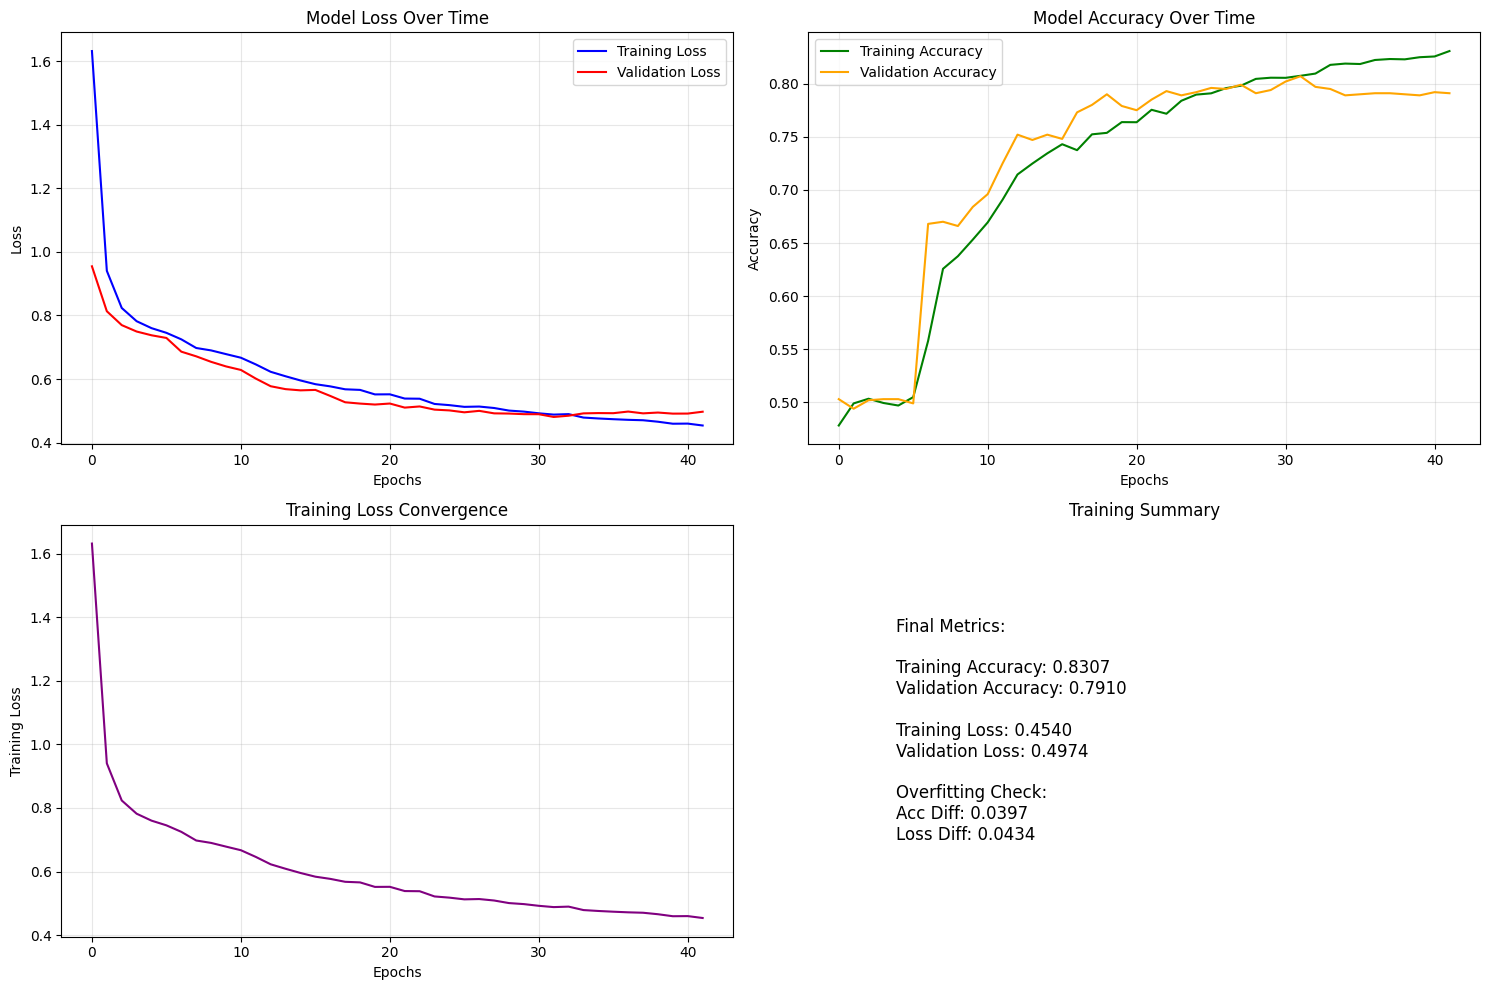

In [17]:
# ENHANCED TRAINING WITH LEARNING RATE SCHEDULING
def setup_improved_callbacks(model_name="best_improved_chatbot.h5"):
    """Configure enhanced training callbacks"""

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Increased patience
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001  # Minimum improvement threshold
        ),
        ModelCheckpoint(
            model_name,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 0.001 * (0.95 ** epoch)
        )
    ]

    return callbacks

# IMPROVED TRAINING FUNCTION
def train_improved_model(model, inputs_train, queries_train, answers_train,
                        inputs_test, queries_test, answers_test,
                        epochs=50, batch_size=64):  # Increased epochs and batch size
    """Train the improved memory network model"""

    print("🚀 Starting improved model training...")

    callbacks = setup_improved_callbacks()

    history = model.fit(
        [inputs_train, queries_train],
        answers_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=([inputs_test, queries_test], answers_test),
        callbacks=callbacks,
        shuffle=True  # Important for better training
    )

    print("✅ Improved training completed!")
    return history

# Assume plot_training_history is defined here or imported from a previous cell
def plot_training_history(history):
    """Visualize training progress"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training & Validation Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Model Loss Over Time')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training & Validation Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', color='green')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axes[0, 1].set_title('Model Accuracy Over Time')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning Rate vs Loss
    axes[1, 0].plot(history.history['loss'], color='purple')
    axes[1, 0].set_title('Training Loss Convergence')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Training Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # Performance Metrics Summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    metrics_text = f"""
    Final Metrics:

    Training Accuracy: {final_train_acc:.4f}
    Validation Accuracy: {final_val_acc:.4f}

    Training Loss: {final_train_loss:.4f}
    Validation Loss: {final_val_loss:.4f}

    Overfitting Check:
    Acc Diff: {final_train_acc - final_val_acc:.4f}
    Loss Diff: {final_val_loss - final_train_loss:.4f}
    """

    axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center')
    axes[1, 1].set_title('Training Summary')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

history_improved = train_improved_model(improved_model, inputs_train, queries_train, answers_train,
                                        inputs_test, queries_test, answers_test)
plot_training_history(history_improved)

# ***Model Evaluation & Performance Metrics***
Evaluation Components:

Prediction Accuracy: Overall correctness
Confidence Analysis: Prediction certainty
Error Analysis: Understanding failure cases
Sample Predictions: Qualitative assessment


📊 Evaluating model performance...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
🎯 Model Performance:
Overall Accuracy: 0.8070

📈 Detailed Classification Report:
              precision    recall  f1-score   support

         yes       0.80      0.82      0.81       497
          no       0.82      0.79      0.80       503

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



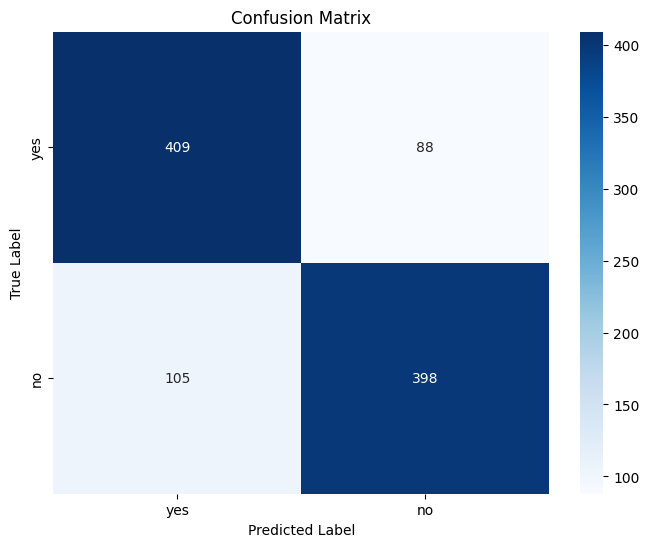

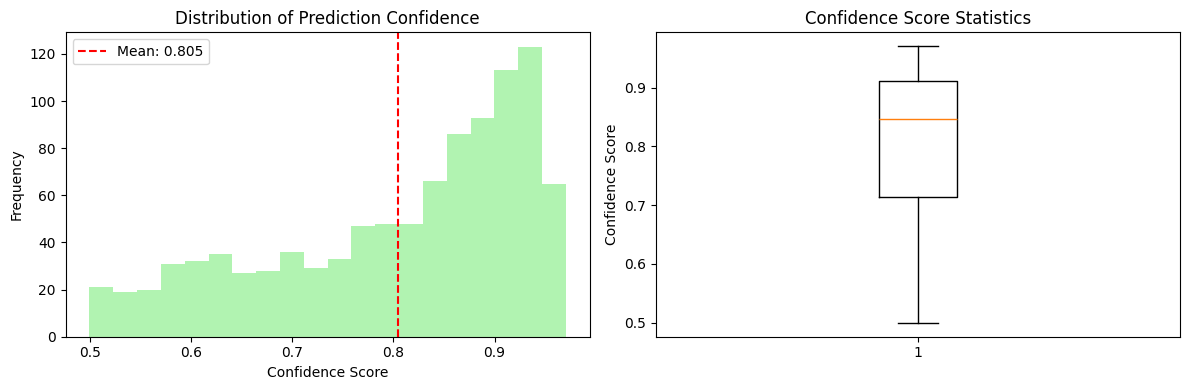

📊 Confidence Statistics:
Mean Confidence: 0.8049
Std Confidence: 0.1270
Min Confidence: 0.4995
Max Confidence: 0.9704
🔍 Sample Predictions Analysis:
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📖 Example 1:
Story: Mary got the milk there . John moved to the bedroom .
Question: Is John in the kitchen ?
True Answer: no
Predicted Answer: no
Confidence: 0.8361
Status: ✅ CORRECT
------------------------------------------------------------

📖 Example 2:
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden .
Question: Is John in the kitchen ?
True Answer: no
Predicted Answer: no
Confidence: 0.5730
Status: ✅ CORRECT
------------------------------------------------------------

📖 Example 3:
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden .
Question: Is John in the garden ?
True Answer: yes
Predicted Answer: yes
Confidence: 

In [18]:
def evaluate_model_performance(model, inputs_test, queries_test, answers_test,
                             test_data, tokenizer):
    """Comprehensive model evaluation"""

    print("📊 Evaluating model performance...")

    # Get predictions
    pred_results = model.predict([inputs_test, queries_test])

    # Calculate accuracy
    predicted_classes = np.argmax(pred_results, axis=1)
    true_classes = np.argmax(answers_test, axis=1)
    accuracy = accuracy_score(true_classes, predicted_classes)

    print(f"🎯 Model Performance:")
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Detailed classification report
    print("\n📈 Detailed Classification Report:")

    # Get class names
    class_names = []
    for idx in [tokenizer.word_index['yes'], tokenizer.word_index['no']]:
        for word, word_idx in tokenizer.word_index.items():
            if word_idx == idx:
                class_names.append(word)

    print(classification_report(true_classes, predicted_classes,
                              target_names=class_names))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return pred_results, accuracy

def analyze_confidence_distribution(pred_results):
    """Analyze prediction confidence"""

    # Get maximum probabilities (confidence scores)
    confidence_scores = np.max(pred_results, axis=1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(confidence_scores, bins=20, alpha=0.7, color='lightgreen')
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(confidence_scores), color='red', linestyle='--',
                label=f'Mean: {np.mean(confidence_scores):.3f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot(confidence_scores)
    plt.title('Confidence Score Statistics')
    plt.ylabel('Confidence Score')

    plt.tight_layout()
    plt.show()

    print(f"📊 Confidence Statistics:")
    print(f"Mean Confidence: {np.mean(confidence_scores):.4f}")
    print(f"Std Confidence: {np.std(confidence_scores):.4f}")
    print(f"Min Confidence: {np.min(confidence_scores):.4f}")
    print(f"Max Confidence: {np.max(confidence_scores):.4f}")

def show_sample_predictions(model, test_data, inputs_test, queries_test,
                           tokenizer, num_samples=5):
    """Display sample predictions with context"""

    print("🔍 Sample Predictions Analysis:")
    print("=" * 60)

    pred_results = model.predict([inputs_test, queries_test])

    for i in range(min(num_samples, len(test_data))):
        # Get story and question
        story = ' '.join(test_data[i][0])
        question = ' '.join(test_data[i][1])
        true_answer = test_data[i][2] # Accessing the answer from the tuple

        # Get predicted answer
        pred_idx = np.argmax(pred_results[i])
        confidence = pred_results[i][pred_idx]

        pred_answer = None
        for word, idx in tokenizer.word_index.items():
            if idx == pred_idx:
                pred_answer = word
                break

        # Display results
        print(f"\n📖 Example {i + 1}:")
        print(f"Story: {story}")
        print(f"Question: {question}")
        print(f"True Answer: {true_answer}")
        print(f"Predicted Answer: {pred_answer}")
        print(f"Confidence: {confidence:.4f}")

        # Status indicator
        status = "✅ CORRECT" if pred_answer == true_answer else "❌ INCORRECT"
        print(f"Status: {status}")
        print("-" * 60)

pred_results, accuracy = evaluate_model_performance(improved_model, inputs_test, queries_test,answers_test, Test_data, tokenizer)
analyze_confidence_distribution(pred_results)
show_sample_predictions(improved_model, Test_data, inputs_test, queries_test, tokenizer)

In [20]:
# COMPREHENSIVE EVALUATION METRICS
def evaluate_comprehensive_metrics(model, inputs_test, queries_test, answers_test,
                                  test_data, tokenizer):
    """Enhanced evaluation with multiple metrics"""

    print("📊 Comprehensive Model Evaluation...")

    # Get predictions
    pred_results = model.predict([inputs_test, queries_test])

    # Calculate multiple metrics
    predicted_classes = np.argmax(pred_results, axis=1)
    true_classes = np.argmax(answers_test, axis=1)

    accuracy = accuracy_score(true_classes, predicted_classes)

    # Calculate confidence statistics
    confidence_scores = np.max(pred_results, axis=1)
    avg_confidence = np.mean(confidence_scores)

    # Calculate class-wise performance
    from sklearn.metrics import precision_score, recall_score, f1_score

    # Handle potential zero division for precision, recall, f1
    precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)


    print(f"🎯 COMPREHENSIVE PERFORMANCE METRICS:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"Average Confidence: {avg_confidence:.4f}")

    # For CV/Resume mention:
    print(f"\n📝 FOR CV/RESUME:")
    print(f"• Achieved {accuracy*100:.1f}% accuracy on question-answering task")
    print(f"• F1-Score: {f1:.3f} with {avg_confidence*100:.1f}% average confidence")
    print(f"• Implemented attention-based Memory Network with BiLSTM-GRU architecture")

    return pred_results, accuracy, precision, recall, f1, avg_confidence

# Evaluate the improved model comprehensively
evaluate_comprehensive_metrics(improved_model, inputs_test, queries_test, answers_test, Test_data, tokenizer)

📊 Comprehensive Model Evaluation...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🎯 COMPREHENSIVE PERFORMANCE METRICS:
Overall Accuracy: 0.8070
Precision (Weighted): 0.8074
Recall (Weighted): 0.8070
F1-Score (Weighted): 0.8070
Average Confidence: 0.8049

📝 FOR CV/RESUME:
• Achieved 80.7% accuracy on question-answering task
• F1-Score: 0.807 with 80.5% average confidence
• Implemented attention-based Memory Network with BiLSTM-GRU architecture


(array([[4.98454392e-05, 4.92599756e-05, 5.03362717e-05, ...,
         8.36134851e-01, 4.86078134e-05, 4.97050678e-05],
        [6.21323779e-05, 6.13887241e-05, 6.27904737e-05, ...,
         5.73003173e-01, 6.05468231e-05, 6.19497878e-05],
        [3.13870878e-05, 3.10008909e-05, 3.17592167e-05, ...,
         9.52202156e-02, 3.05533504e-05, 3.12909106e-05],
        ...,
        [3.50850642e-05, 3.46783272e-05, 3.54131225e-05, ...,
         9.36044514e-01, 3.42295971e-05, 3.49885340e-05],
        [3.39718899e-05, 3.35546574e-05, 3.43714528e-05, ...,
         1.10136345e-01, 3.30713847e-05, 3.38680802e-05],
        [4.47625644e-05, 4.42181590e-05, 4.52707791e-05, ...,
         2.01062396e-01, 4.35947732e-05, 4.46291051e-05]], dtype=float32),
 0.807,
 0.8073945733455029,
 0.807,
 0.8069639046324605,
 np.float32(0.8048741))